In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression as modl

class MyLogReg():

    def __init__(self, n_iter=5000, learning_rate=0.01, weights=None, metric=None, reg=None,
                l1_coef=0, l2_coef=0):
        self.n_iter = n_iter
        self.learning_rate = learning_rate
        self.weights = weights
        self.metric = metric
        self.metric_value = None
        self.reg = reg
        self.l1_coef = l1_coef
        self.l2_coef = l2_coef 
        
    def __str__(self):
        return f'MyLogReg class: n_iter={self.n_iter}, learning_rate={self.learning_rate}'
    
    def fit(self, X, y, verbose=False):
        n = len(X)
        y = np.array(y)
        m = len(X.columns)
        X.insert(0, 'x0', [1] * n)
        self.weights = np.zeros(m + 1)
        eps = 1e-15
        error = []
        for i in range(self.n_iter):
            y_pred = 1 / (1 + np.exp(-np.dot(X, self.weights)))
            LogLoss = -(1 / n) * np.sum(y * np.log(y_pred) + (1 - y) * np.log(1 - y_pred))  + self.regularization()[0] / n
            grad = (1 / n) * np.dot((y_pred - y), X) + self.regularization()[1]  / n
            self.weights = self.weights - self.learning_rate * grad
            error.append(LogLoss)
        del X['x0']
        return (self.weights, error)
        
    def get_coef(self):
        return np.sum(self.weights[1:])
    
    def predict_proba(self, X):
        if not(len(self.weights) == len(X.columns)):
            n = len(X)
            X.insert(0, 'x0', [1] * n)
        prb = 1 / (1 + np.exp(-np.dot(X, self.weights)))
        return prb
    
    def predict(self, X):
        if not(len(self.weights) == len(X.columns)):
            n = len(X)
            X.insert(0, 'x0', [1] * n)
        prb = 1 / (1 + np.exp(-np.dot(X, self.weights)))
        y_pred = self.classification(prb, 0.5)
        return int(sum(y_pred))
    
    def metrics(self, y_pred, y):
            TP = np.count_nonzero((y_pred == 1) & (y_pred == y))
            TN = np.count_nonzero((y_pred == 0) & (y_pred == y))
            FN = np.count_nonzero((y_pred == 0) & (y_pred != y))
            FP = np.count_nonzero((y_pred == 1) & (y_pred != y))
            accuracy = (TP + TN) / (TP + TN + FN + FP)
            metrics = {'accuracy': accuracy}
            return metrics[self.metric]
    
    def classification(self, pred):
        classes = np.zeros_like(pred)
        classes[pred >= 0] = 1
        classes[pred < 0] = 0
        return classes
    
    def get_best_score(self):
        return self.metric_value
    
    def regularization(self):
        l1 = self.l1_coef * sum(np.abs(self.weights[1:]))
        l2 = self.l2_coef * sum((self.weights[1:])**2)
        gr1 = np.zeros_like(self.weights)
        gr1[1:] = self.l1_coef * np.sign(self.weights[1:])
        gr2 = np.zeros_like(self.weights)
        gr2[1:] = 2 * self.l2_coef * self.weights[1:]
        regul = {'l1': l1,
                 'l2': l2,
                 'elasticnet': l1 + l2,
                 None: 0}
        regul_grad = {'l1': gr1,
                      'l2': gr2,
                      'elasticnet': gr1 + gr2,
                      None: 0}
        return (regul[self.reg], regul_grad[self.reg])

In [3]:
def features(x1, x2):
    lst = []
    for i in range(31):
        for j in range(31):
            if (i + j) <= 30:
                lst.append((x1 ** i) * (x2 ** j))
    data = np.array(lst)
    data1 = data.transpose()
    df = pd.DataFrame({i + i: data[:, i] for i in range(data1.shape[0])})
    new = df.T
    return new

In [4]:
def normalize(df):
    df = df.to_numpy()
    arr = df.transpose()
    new = np.zeros_like(arr)
    for i in range(arr.shape[0]):
        new[i,:] = (arr[i,:] - np.mean(arr[i,:])) / np.std(arr[i,:])
    new_transpose = new.transpose()
    res = pd.DataFrame(data=new_transpose)
    return res

In [5]:
from sklearn.model_selection import train_test_split

df = pd.read_csv('ex2data2.csv', names=['x1', 'x2', 'y'])
X = features(np.array(df['x1']), np.array(df['x2']))
X_train, X_test, y_train, y_test = train_test_split(X, df['y'], test_size=0.2, random_state=42)
X_train = normalize(X_train)
X_test = normalize(X_test)
del X_test[0]
X_test.insert(0, 0, [1] * len(X_test))
del X_train[0]

/tmp/ipykernel_4161/3058363186.py:6: RuntimeWarning: invalid value encountered in divide
  new[i,:] = (arr[i,:] - np.mean(arr[i,:])) / np.std(arr[i,:])
/tmp/ipykernel_4161/1840434666.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X_test.insert(0, 0, [1] * len(X_test))


/tmp/ipykernel_4161/3602688534.py:26: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X.insert(0, 'x0', [1] * n)


точность для тренировочной: 0.925531914893617
точность для тестовой: 0.75
точность для тренировочной с регуляризацией: 0.851063829787234
точность для тестовой с регуляризацией: 0.8333333333333334


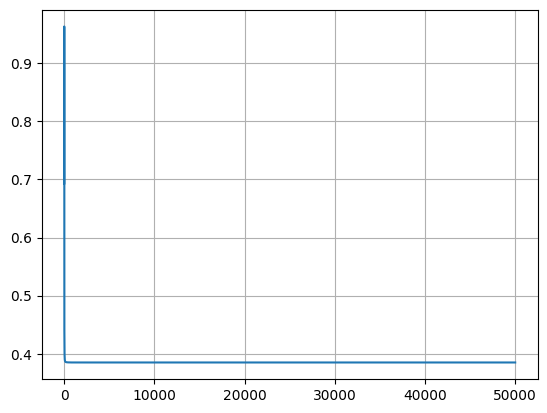

In [6]:
model = MyLogReg(n_iter=50000, learning_rate=0.5, metric='accuracy')
weights_error = model.fit(X_train, y_train)
X_train.insert(0, 'x0', [1] * len(X_train))
weights, error = weights_error[0], weights_error[1]
y_pred_train = np.dot(X_train, weights)
y_pred_test = np.dot(X_test, weights)
y_classes_train = model.classification(y_pred_train)
y_classes_test = model.classification(y_pred_test)
#plt.plot(np.arange(len(error)), error)
# plt.title('Без регуляризации')
# plt.legend()
# plt.grid(True)
print(f'точность для тренировочной: {model.metrics(y_classes_train, y_train)}')
print(f'точность для тестовой: {model.metrics(y_classes_test, y_test)}')
del X_train['x0']





model_reg = MyLogReg(n_iter=50000, learning_rate=0.5, l2_coef=1.0, metric='accuracy', reg='l2')
weights_error_reg = model_reg.fit(X_train, y_train)
X_train.insert(0, 'x0', [1] * len(X_train))
weights_reg, error_reg = weights_error_reg[0], weights_error_reg[1]
y_pred_train_reg = np.dot(X_train, weights_reg)
y_pred_test_reg = np.dot(X_test, weights_reg)
y_classes_train_reg = model.classification(y_pred_train_reg)
y_classes_test_reg = model.classification(y_pred_test_reg)
#plt.plot(np.arange(len(error)), error)
# plt.title('Без регуляризации')
# plt.legend()
# plt.grid(True)
print(f'точность для тренировочной с регуляризацией: {model_reg.metrics(y_classes_train_reg, y_train)}')
print(f'точность для тестовой с регуляризацией: {model_reg.metrics(y_classes_test_reg, y_test)}')
del X_train['x0']
plt.plot(np.arange(len(error_reg)), error_reg)
plt.grid(True)
plt.show()

/tmp/ipykernel_4161/3058363186.py:6: RuntimeWarning: invalid value encountered in divide
  new[i,:] = (arr[i,:] - np.mean(arr[i,:])) / np.std(arr[i,:])
/tmp/ipykernel_4161/2859822535.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  Z.insert(0,0,[1] * len(Z))
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


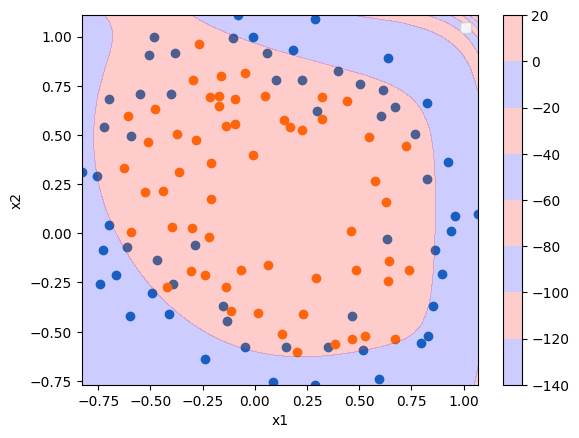

In [8]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

def plot(X, y, theta):
    plt.scatter(X['x1'].loc[df['y'] == 0], X['x2'].loc[df['y'] == 0])
    plt.scatter(X['x1'].loc[df['y'] == 1], X['x2'].loc[df['y'] == 1])
    
    X = X.to_numpy()
    x_min, x_max = X[:, 0].min(), X[:, 0].max()
    y_min, y_max = X[:, 1].min(), X[:, 1].max()
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 50), np.linspace(y_min, y_max, 50))
    
    Z = features(xx.ravel(), yy.ravel())
    Z = normalize(Z)
    del Z[0]
    Z.insert(0,0,[1] * len(Z))
    #Z = scaler.fit_transform(Z)  # Apply the same scaling to the features for contour plotting
    Z = Z.dot(theta)
    Z = Z.to_numpy()
    Z = Z.reshape(xx.shape)
    contour = plt.contourf(xx, yy, Z, alpha=0.2, colors=['blue', 'red'])
    
    plt.xlabel('x1')
    plt.ylabel('x2')
    plt.legend()
    plt.colorbar(contour)
    plt.show()
    
plot(df[['x1','x2']], df['y'], weights_reg)

/tmp/ipykernel_4161/3058363186.py:6: RuntimeWarning: invalid value encountered in divide
  new[i,:] = (arr[i,:] - np.mean(arr[i,:])) / np.std(arr[i,:])
/tmp/ipykernel_4161/1797024144.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  Z.insert(0,0,[1] * len(Z))
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


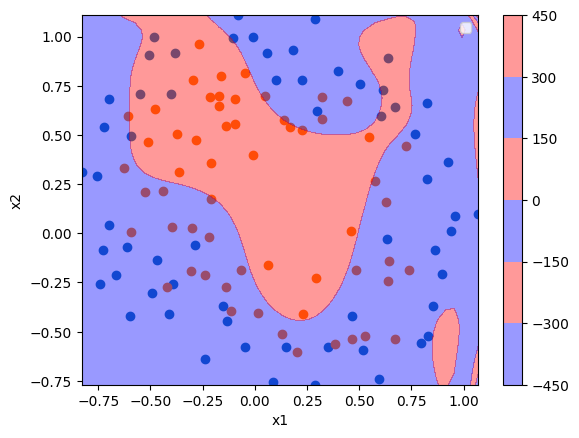

In [7]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

def plot(X, y, theta):
    plt.scatter(X['x1'].loc[df['y'] == 0], X['x2'].loc[df['y'] == 0])
    plt.scatter(X['x1'].loc[df['y'] == 1], X['x2'].loc[df['y'] == 1])
    
    X = X.to_numpy()
    x_min, x_max = X[:, 0].min(), X[:, 0].max()
    y_min, y_max = X[:, 1].min(), X[:, 1].max()
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 50), np.linspace(y_min, y_max, 50))
    
    Z = features(xx.ravel(), yy.ravel())
    Z = normalize(Z)
    del Z[0]
    Z.insert(0,0,[1] * len(Z))
    #Z = scaler.fit_transform(Z)  # Apply the same scaling to the features for contour plotting
    Z = Z.dot(theta)
    Z = Z.to_numpy()
    Z = Z.reshape(xx.shape)
    contour = plt.contourf(xx, yy, Z, alpha=0.4, colors=['blue', 'red'])
    
    plt.xlabel('x1')
    plt.ylabel('x2')
    plt.legend()
    plt.colorbar(contour)
    plt.show()
    
plot(df[['x1','x2']], df['y'], weights)